In [1]:
from os import path
if not ( path.exists('c2db.db') or path.exists('typeIII.pickle') ):
  !curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location 'https://api.github.com/repos/mayhd3/DIPC/contents/typeIII.pickle'


In [2]:
import sys
try:
    import ase.db
except ImportError:
    !{sys.executable} -m pip install ase asr gpaw
    import ase.db
import pickle
from itertools import product

print("Collecting type III heterojunctions...")

# Check that a is in ascending order
def ascending(a): return all(
    a[i]<a[i+1] for i in range(len(a)-1)
)

def candidate(left, right):
    # Apply attr to each combination of band energies with given suffix
    def calculation(attr, suffix): return (
        attr(row,band)
            for row in (left,right)
            for band in ('vbm'+suffix,'cbm'+suffix)
    )

    # Find the x-y*n closest to 0
    def fit(l, r):
        y = min(abs(l),abs(r))
        if y==0:
            return 0
        x = max(abs(l),abs(r))
        return ((x + y/2)%y) - y/2

    # Find the sum of the fits of the lattice parameters
    def fit_lat(l, r):
        (l_lat, r_lat) = (
            row.data['results-asr.structureinfo.json']['kwargs']['data']['spglib_dataset']['std_lattice']
                for row in (l, r)
        )
        return sum(( abs(fit(l_lat[y][x], r_lat[y][x])) for x, y in product((0,1,2), repeat=2) ))
    
    def wrtevac(gaps): # Align band gaps on evac=0
        return (
            gaps[0] - left.evac,
            gaps[1] - left.evac,
            gaps[2] - right.evac,
            gaps[3] - right.evac
        )

    structures = list( # Compare bands calculated with the same functional, prefer G0W0 > HSE > PBE
        (func,calc)
        for func,calc in (
            (func,wrtevac(list(calculation(getattr,suffix))))
            for func,suffix in (('GW','_gw'),('HSE','_hse'),('PBE',''))
            if all(calculation(hasattr,suffix))
        )
        if ascending(calc) # Gap is broken and bands are rising
    )

    if all((
        left.thermodynamic_stability_level == 3, # Only accept thermodynamically stable materials
        right.thermodynamic_stability_level == 3, 
        left.is_magnetic == 0, # Do not accept magnetic materials
        right.is_magnetic == 0,
        getattr(left,'class',None) == getattr(right,'class',None), # Materials must have the same phase
        left.spgnum == right.spgnum, # Materials must have the same space group
        left.crystal_type == right.crystal_type, # Materials must have the same crystal structure
        not 'C' in left.crystal_type, # Only accept A or AB type crystal structures
        bool(structures) # At least one functional calculates a type III heterojunction band structure
    )):
        calcs,bands = zip(*structures)
        return (
            left.formula,                   #0
            left.uid,                       #1
            right.formula,                  #2
            right.uid,                      #3
            calcs,                          #4
            bands,                          #5
            getattr(left,'class',None),     #6
            left.spacegroup,                #7
            left.crystal_type,              #8
            calcs[0][3] - calcs[0][0],      #9
            left.cell_area/right.cell_area, #10
            fit_lat(left,right)             #11
        )

headers = [     # The title of each candidate column
    'Left',     #0
    'uid',      #1
    'Right',    #2
    'uid',      #3
    'Calcs',    #4
    'Bands',    #5 
    'Class',    #6
    'Group',    #7
    'Type',     #8
    'ΔE',       #9
    'R',        #10
    'ΔL'        #11
]

try:
    with open('typeIII.pickle','rb') as pk:
        typeIII = pickle.load(pk)
        print("Loaded from pickle.")
except (OSError, IOError):
    # Connect to the database
    db = ase.db.connect('c2db.db')
    # Find rows that have all of the parameters used to choose candidates
    rows = list(db.select('evac,thermodynamic_stability_level,is_magnetic,spgnum,crystal_type,has_asr_structureinfo'))
    # Find pairs of rows that could be type III heterojunctions
    typeIII = sorted(
        list( filter(
            lambda row: row != None, # Remove pairs that were not candidates
            [candidate(l,r) for l in rows for r in rows] # Take every pair in the selection
        ) ),
        key = lambda t: t[11] # Sort by how well the lattices fit
    )
    print("Loaded from ase db.")
    with open('typeIII.pickle','wb') as pk: # Cache results to make plot changes load faster
        pickle.dump(typeIII, pk)
        print("Dumped to pickle.")

Loaded from pickle.


In [3]:
import pandas as pd
from tabulate import tabulate

spgs = pd.unique([t[7] for t in typeIII]) # Find which space groups we found pairs from
print("Collected " + str(len(typeIII)) + " type III heterojunctions from " + str(len(spgs)) + " space groups:")

best = [ next(t for t in typeIII if t[7] == s) for s in spgs ] # The best pair from each spacegroup

def pretty(pair,calc):
    return [
        *pair[:4],
        ",".join(pair[4]),
        ",".join(map("{:.3f}".format, pair[5][pair[4].index(calc)])),
        *pair[6:]
    ]

print(tabulate([pretty(pair,pair[4][0]) for pair in best], headers, floatfmt='.3f')) # Print out a table of the best pairs

Collected 737 type III heterojunctions from 15 space groups:
Left    uid                  Right    uid                  Calcs    Bands                        Class    Group    Type           ΔE      R     ΔL
------  -------------------  -------  -------------------  -------  ---------------------------  -------  -------  ----------  -----  -----  -----
Hg2Se2  Hg2Se2-f2919d1605f0  In2I2    I2In2-9ab97b2e26fc   HSE,PBE  -6.096,-5.808,-5.723,-4.389           P-1      AB-2-i      1.708  0.999  0.004
PdS2    PdS2-02762a09ebbf    NiSe2    NiSe2-c1ffa88ee5ca   PBE      -6.292,-5.121,-4.876,-4.816  TMDC-T   P-3m1    AB2-164-bd  1.476  1.007  0.030
Mo2Se4  Mo2Se4-82a84bbe4a89  W2Se4    W2Se4-800574ca4834   PBE      -5.121,-5.079,-4.954,-4.923  TMDC-T'  P2_1/m   AB2-11-e    0.198  0.996  0.033
Tl2Cl6  Tl2Cl6-428082203077  Co2I6    Co2I6-04fd9e7d4375   PBE      -8.150,-5.724,-5.137,-4.611           P-31m    AB3-162-dk  3.539  1.010  0.142
TiSe2   TiSe2-509ef368050d   CrTe2    CrTe2-c31911a1b3f9 

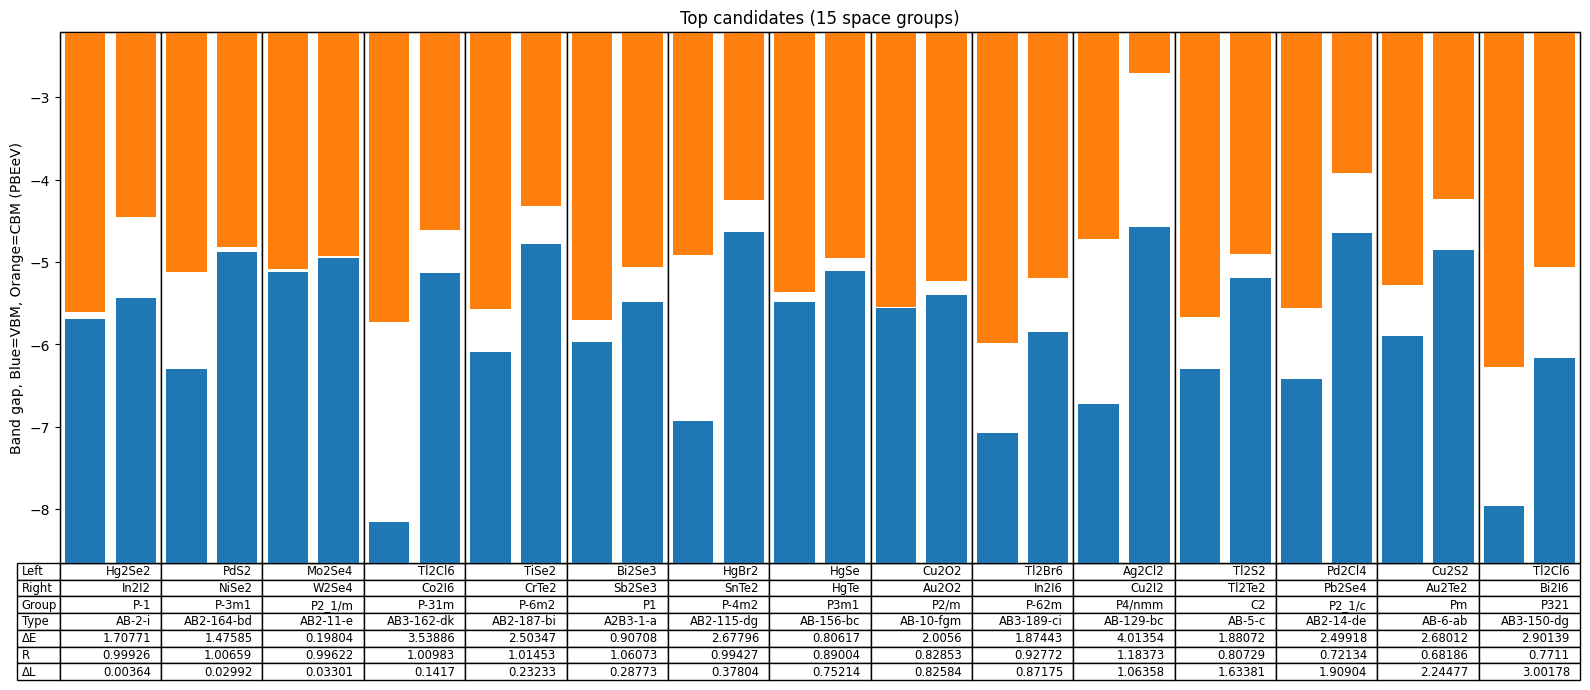

In [6]:

import numpy as np
import matplotlib.pyplot as plt

table_headers_indices = [0,2,7,8,9,10,11] # Which headers to display in the table

def bands_with_table(pairs,calc): # Plot each pair of candidates, with bars for the band gaps, and a table for other stats
    ax = plt.subplot(label=str(id(pairs)))
    ax.margins(x=0)

    flatx = range(len(pairs)*2)

    if(not flatx): # Empty graph
        return

    [leftvbm, leftcbm, rightvbm, rightcbm] = np.transpose([pair[5][pair[4].index(calc)] for pair in pairs])
    emin = np.amin(leftvbm) - .5
    emax = np.amax(rightcbm) + .5

    leftx = flatx[::2]
    ax.bar(leftx, leftvbm-emin, bottom=emin, color='C0')
    ax.bar(leftx, leftcbm-emax, bottom=emax, color='C1')
    #ax.bar(leftx, leftvbm-leftcbm, bottom=leftcbm)

    rightx = flatx[1::2]
    ax.bar(rightx, rightvbm-emin, bottom=emin)
    ax.bar(rightx, rightcbm-emax, bottom=emax)
    #ax.bar(rightx, rightvbm-rightcbm, bottom=rightcbm)

    ax.set_xlim(-.5,len(flatx)-.5)
    ax.set_ylim(emin,emax)

    plt.xticks([],[])

    table = plt.table(
        cellText=[
            [ pair[i] if not isinstance(pair[i], float) else round(pair[i],5) for pair in pairs ]
            for i in table_headers_indices
        ],
        rowLabels=[headers[i] for i in table_headers_indices],
        loc='bottom'
    )
    table.auto_set_font_size(False)
    table.set_fontsize('small')

    plt.table(
        cellText = [['' for x in leftx]],
        bbox=[0,0,1,1]
    )

    plt.ylabel('Band gap, Blue=VBM, Orange=CBM (' + calc + ' eV)')

plt.figure(figsize=(16,7),dpi=100)
bands_with_table(best,'PBE')
plt.title("Top candidates (" + str(len(spgs)) + " space groups)")
plt.tight_layout()

plt.show()

In [5]:
from IPython.display import display
import ipywidgets as widgets

radio = widgets.RadioButtons(
    options=('GW','HSE','PBE'),
    value='HSE',
    description='Calculation:',
    style={'description_width': 'initial'}
)

ddown = widgets.Dropdown(
    options=spgs,
    description='Space group:',
    style={'description_width': 'initial'}
)

slide = widgets.IntRangeSlider(
    value=(0,20),
    description='Candidate indices:',
    style={'description_width': 'initial'},
    disabled=False
)

functional = None
spacegroup = None

def selected_max(event):
    slide.max = len(spacegroup)
    upper = min(slide.value[1],slide.max)
    lower = min(slide.value[0],upper)
    slide.value = (lower,upper)

def selected(event):
    global spacegroup
    spacegroup = [row for row in functional if row[7] == ddown.value] # Rows in this group
    selected_max(None)

def toggled(event):
    global functional
    functional = [row for row in typeIII if radio.value in row[4]]
    selected(None)

ddown.observe(selected, names='value')
radio.observe(toggled, names='value')

toggled(None)

bands = widgets.Button(description='VBM, CBM')
ratio = widgets.Button(description='ΔE, R')

output = widgets.Output()

def pressed(button):
    with output:
        output.clear_output(wait=True)
        top = spacegroup[slide.value[0]:slide.value[1]] # Top 20 rows in this space group
        plt.figure(figsize=(16,7),dpi=100)
        if button==bands:
            bands_with_table(top,radio.value)
        if button==ratio:
            plt.scatter(
                x=[s[9] for s in top],
                y=[s[10] for s in top]
            )
            for s in top: # Label scatter plot points with formulas
                plt.annotate(s[0]+","+s[2],(s[9],s[10]))
            plt.xlabel(headers[9] + " (eV)")
            plt.ylabel(headers[10] + " (1)")

        plt.title(ddown.value + " (top " + str(slide.value[0]) + "-" + str(slide.value[1]) + " of " + str(len(spacegroup)) + " candidates)")
        plt.tight_layout()
        plt.show()

        for row in range(len(top)):
            tup = list(top[row])
            tup[1] = '<a target="_blank" href="' + 'https://cmrdb.fysik.dtu.dk/c2db/row/' + tup[1] + '">' + tup[1] + '</a>'
            tup[3] = '<a target="_blank" href="' + 'https://cmrdb.fysik.dtu.dk/c2db/row/' + tup[3] + '">' + tup[3] + '</a>'
            top[row] = tup

        display(widgets.HTML(
            "<style>tr:hover { background-color: gainsboro !important; } tr { background-color: white !important; }</style>" +
            tabulate([pretty(pair,radio.value) for pair in top], headers, floatfmt=".3f", tablefmt="unsafehtml")
        ))

bands.on_click(pressed)
ratio.on_click(pressed)

display(radio, ddown, slide, bands, ratio, output)

RadioButtons(description='Calculation:', index=1, options=('GW', 'HSE', 'PBE'), style=DescriptionStyle(descrip…

Dropdown(description='Space group:', options=('P-1', 'P-3m1', 'P2_1/m', 'P-31m', 'P-6m2', 'P1', 'P-4m2', 'P3m1…

IntRangeSlider(value=(0, 20), description='Candidate indices:', max=49, style=SliderStyle(description_width='i…

Button(description='VBM, CBM', style=ButtonStyle())

Button(description='ΔE, R', style=ButtonStyle())

Output()